This notebook illustrates the main features of the Community Simulator package. 

# The Model

The Community Simulator is an open-ended platform, which can incorporate any ODE model based on concentrations of consumers and resources. The module comes with a built-in script for constructing variants of the MacArthur Consumer Resource Model (CRM), allowing for crossfeeding, metabolic regulation, and type I, II and III response functions. The full description of the range of modeling capabilities will be described in the documentation accompanying a future release. In this notebook, we will focus on the MacArthur CRM with type I response and independent metabolic fluxes. At the end, we will also briefly introduce the crossfeeding term.

In the MacArthur CRM with resource regeneration turned off (in order to model batch culture), the populations $N_i$ of $S$ distinct species and the concentrations $R_\alpha$ of $M$ distinct resources evolve according to the following ODE's:

\begin{align}
\frac{dN_i}{dt} &= N_i g_i\left[ \sum_\beta c_{i\beta}w_\beta R_\beta - m_i\right]\\
\frac{dR_\alpha}{dt} &= - R_\alpha\sum_j c_{j\alpha}N_j.
\end{align}

For now, we will measure resource concentrations in units of biomass equivalent, so that $w_\alpha = 1$. The remaining parameters $c_{i\alpha}$ and $m_i$ will be explained in the following sections.

The functions `MakeResourceDynamics` and `MakeConsumerDynamics` in the `usertools` submodule construct the right-hand sides of these equations as functions of the $N_i$ and $R_\alpha$ vectors. The keyword arguments specify the modeling assumptions concerning response type, regulation, and replenishment of resources:

In [1]:
from community_simulator.usertools import MakeConsumerDynamics,MakeResourceDynamics

assumptions = {'response':'type I','regulation':'independent','replenishment':'off'}

def dNdt(N,R,params):
    return MakeConsumerDynamics(**assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(**assumptions)(N,R,params)

Defining these functions at the top level of your code allows them to be pickled and sent to multiple CPU's during built-in parallel execution.

## Load parameters from Excel

Community Simulator is designed to work with Pandas, a powerful data science module that comes pre-installed with the Anaconda Python distribution. We can use Pandas to load in the parameters for our simulation from a Microsoft Excel spreadsheet. 

The Pandas syntax is very straightforward: you just feed the `read_excel` function the filename of the spreadsheet, and (if there are multiple sheets in the workbook) the name of the sheet you want to load. The workbook `test_data.xlsx` included with this distribution contains six sheets, with all the information required to run a simple experiment.

## Consumption Matrix

Let's start by loading the consumption matrix $c_{i\alpha}$, which is the heart of the MacArthur Consumer Resource Model (CRM) and all its variants:

In [2]:
import pandas as pd
c = pd.read_excel('data/test_data.xlsx',sheet_name='Consumption')
c

,Glutamine,Citrate,R2,R3,R4,R5,R6,R7,R8
Enterobacter,1.000,0.001,0.01,0.01,0.01,0.01,0.01,0.01,0.01
Pseudomonas,0.001,0.990,0.01,0.01,0.01,0.01,0.01,0.01,0.01
Flavobacter,0.480,0.490,0.01,0.01,0.01,0.01,0.01,0.01,0.01
Enterococca,0.490,0.480,0.01,0.01,0.01,0.01,0.01,0.01,0.01


This matrix specifies the per capita consumption rate of each nutrient for each species. The vector of consumption rates is what defines a species for the purposes of the model. I have given the two primary carbon sources realistic names, and also supplied a low level of six "unknown" resources. (Note: These are not meant to be the actual consumption vectors for the four bacterial strains listed here; the only purpose of the names is to make clear that each row represents a distinct strain.)

## Cost Vector

The MacArthur CRM contains another important set of parameters, which are the minimal consumption rates $m_i$ required for survival. For this example, we will set all of them to be equal:

In [3]:
import pandas as pd
m = pd.read_excel('data/test_data.xlsx',sheet_name='Cost')
m

,Cost
Enterobacter,0.001
Pseudomonas,0.001
Flavobacter,0.001
Enterococca,0.001


## Initial Conditions

Now let's set the initial cell densities $N_i(0)$ in each wells of our example four-well plate:

In [4]:
N0 = pd.read_excel('data/test_data.xlsx',sheet_name='Populations')
N0

,well1,well2,well3,well4
Enterobacter,1,0,1,0
Pseudomonas,1,0,0,0
Flavobacter,0,1,0,0
Enterococca,0,1,0,0


I have kept one well empty for doing a coalescence experiment later on, and one well contains the most abundant species ("champion") from well1 (as we will see below). When we perform serial dilution experiments later on, the absolute numbers of individuals will be important. By default, the density is measured in units of $10^9$ cells/well. 

Another sheet lists the initial concentrations of nutrients $R_\alpha(0)$ in each well:

In [5]:
R0 = pd.read_excel('data/test_data.xlsx',sheet_name='Resources')
R0

,well1,well2,well3,well4
Glutamine,1.0000,1.0000,1.0000,1.0000
Citrate,1.0000,1.0000,1.0000,1.0000
R2,0.0001,0.0001,0.0001,0.0001
R3,0.0001,0.0001,0.0001,0.0001
R4,0.0001,0.0001,0.0001,0.0001
R5,0.0001,0.0001,0.0001,0.0001
R6,0.0001,0.0001,0.0001,0.0001
R7,0.0001,0.0001,0.0001,0.0001
R8,0.0001,0.0001,0.0001,0.0001


These concentrations will be supplied to these wells every time we passage the cells. 

## Protocol

The feature that really makes this Community Simulator package unique is the built-in passaging functionality. The Passage method takes as an argument a matrix $f$ like this one:

In [6]:
f_dilute = pd.read_excel('data/test_data.xlsx',sheet_name='Dilute')
f_dilute

,well1,well2,well3,well4
well1 new,0.001,0.000,0.000,0.000
well2 new,0.000,0.001,0.000,0.000
well3 new,0.000,0.000,0.001,0.000
well4 new,0.000,0.000,0.000,0.001


The matrix specifies what fraction of each well should be loaded into each of the fresh wells. This is where the absolute number of cells in each well becomes important, because the program always loads an integer number of cells of each species into the new wells, choosing these numbers by multinomial sampling.

This particular matrix is a simple dilution protocol, taking 0.1% of each well and loading it into the corresponding well on the new plate. But we can also make more complicated protocols, like this one for performing a coalescence experiment: 

In [7]:
f_mix = pd.read_excel('data/test_data.xlsx',sheet_name='Mix')
f_mix

,well1,well2,well3,well4
well1 new,0.001,0.000,0.000,0
well2 new,0.000,0.001,0.000,0
well3 new,0.001,0.001,0.000,0
well4 new,0.000,0.001,0.001,0


This performs a standard dilution in wells 1 and 2, but then mixes the contents of wells 1 and 2 in well 3, and mixes the "champion" of well1 with the well2 community in well4. We can also build matrices to simulate diffusion, mixing each well with its neighbors at each step. 

# The Community Class

With all these variables loaded, we can now create an instance of the "Community" class. This instance will contain the current population levels and resource concentrations in each well, and also holds the equations and the parameters that define the model. 

In [8]:
from community_simulator import Community
import numpy as np
from community_simulator.usertools import MakeConsumerDynamics,MakeResourceDynamics
import pandas as pd

init_state = [pd.read_excel('data/test_data.xlsx',sheet_name='Populations'),
              pd.read_excel('data/test_data.xlsx',sheet_name='Resources')]

assumptions = {'regulation':'independent','replenishment':'off','response':'type I'}
def dNdt(N,R,params):
    return MakeConsumerDynamics(**assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(**assumptions)(N,R,params)
dynamics = [dNdt,dRdt]

params={'c':pd.read_excel('data/test_data.xlsx',sheet_name='Consumption'),
        'm':pd.read_excel('data/test_data.xlsx',sheet_name='Cost'),
        'w':np.ones(len(init_state[1])),
        'g':np.ones(len(init_state[0]))
       }


MyPlate = Community(init_state,dynamics,params,scale=10**9)

"Community" takes three mandatory arguments for initialization: the initial state, the dynamics, and the parameters. There is also an option for adjusting the units of $N_i$, which are set by default to $10^9$/well.

We can test whether things are working by following the population of a single well over time:

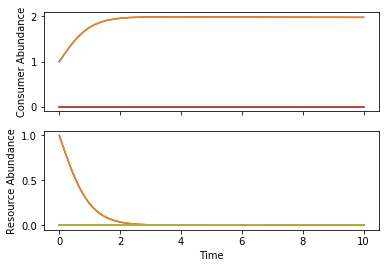

In [9]:
t, Ntraj, Rtraj = MyPlate.TestWell(T=10)

The basic methods of the `Community` class are `Propagate`, which simply runs the model for a fixed amount of time, and `Passage`, which passages the cells to a fresh plate following the protocol matrix $f$ that is passed as an argument.

In [10]:
f_dilute = pd.read_excel('data/test_data.xlsx',sheet_name='Dilute')
MyPlate.Passage(f_dilute)
MyPlate.N

,well1,well2,well3,well4
Enterobacter,0.001,0.000000,0.001,0.0
Pseudomonas,0.001,0.000000,0.000,0.0
Flavobacter,0.000,0.000999,0.000,0.0
Enterococca,0.000,0.001001,0.000,0.0


We can automatically run $n$ serial dilutions using protocol $f$ at fixed time intervals $T$ using the `RunExperiment` method:

In [11]:
n = 10
T = 10
Ntraj,Rtraj=MyPlate.RunExperiment(f_dilute,T,n)
MyPlate.N

,well1,well2,well3,well4
Enterobacter,0.954912,0.000000,0.958298,0.0
Pseudomonas,0.950310,0.000000,0.000000,0.0
Flavobacter,0.000000,0.915726,0.000000,0.0
Enterococca,0.000000,0.963227,0.000000,0.0


Note that `RunExperiment` returns trajectory outputs `Ntraj` and `Rtraj`, which are multiindex dataframes:

In [12]:
Ntraj

Enterobacter  Pseudomonas  Flavobacter  Enterococca
Time Well                                                      
0    well1      0.001000     0.001000     0.000000     0.000000
     well2      0.000000     0.000000     0.000999     0.001001
     well3      0.001000     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
10   well1      0.054134     0.052085     0.000000     0.000000
     well2      0.000000     0.000000     0.040459     0.042280
     well3      0.055430     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
20   well1      0.569019     0.534392     0.000000     0.000000
     well2      0.000000     0.000000     0.416996     0.435332
     well3      0.575601     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
30   well1      0.928938     0.917438     0.000000     0.000000
     well2      0.000000     0.000000     0.860879     0.897996
     well3      0.932368     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
40   well1      0.953812     0.948733     0.000000     0.000000
     well2      0.000000     0.000000     0.915197     0.956478
     well3      0.957160     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
50   well1      0.954885     0.950217     0.000000     0.000000
     well2      0.000000     0.000000     0.917517     0.961022
     well3      0.958250     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
60   well1      0.954946     0.950267     0.000000     0.000000
     well2      0.000000     0.000000     0.917339     0.961593
     well3      0.958296     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
70   well1      0.954896     0.950328     0.000000     0.000000
     well2      0.000000     0.000000     0.917545     0.961409
     well3      0.958298     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
80   well1      0.954931     0.950289     0.000000     0.000000
     well2      0.000000     0.000000     0.916164     0.962791
     well3      0.958298     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
90   well1      0.954947     0.950271     0.000000     0.000000
     well2      0.000000     0.000000     0.916012     0.962943
     well3      0.958298     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000
100  well1      0.954912     0.950310     0.000000     0.000000
     well2      0.000000     0.000000     0.915726     0.963227
     well3      0.958298     0.000000     0.000000     0.000000
     well4      0.000000     0.000000     0.000000     0.000000

# Run a little experiment

Now let's use our mixing protocol to compare the performance of the "champion" of Well 1 in competition against the two species of Well 2, with and without the other species from Well 2:

In [13]:
f_mix = pd.read_excel('data/test_data.xlsx',sheet_name='Mix')
MyPlate.Passage(f_mix)
MyPlate.Propagate(T)
Ntraj,Rtraj=MyPlate.RunExperiment(f_dilute,T,n)

We can plot the trajectory using `PlotTraj` from the `visualization` submodule as `PlotTraj(Ntraj)`:

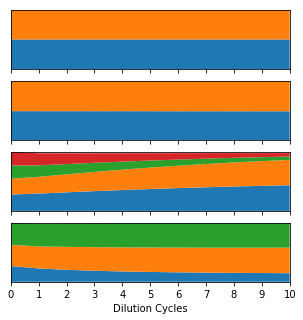

In [14]:
from community_simulator.visualization import PlotTraj
import matplotlib.pyplot as plt
%matplotlib inline
PlotTraj(Ntraj,figsize=(5,5))
plt.show()

The four panels represent the four wells. Each color is a species, and the thickness of the colored bar at each dilution cycle is proportional to the population of that species at the end of that cycle. 

The first two panels are controls, which simply propagate the two initial communities (which I will call 'A' and 'B'). The third panel shows the result of invading B with all of A, as can be seen by the presence of all four colors. The fourth is the invasion by the "champion" alone, which is the blue Enterobacter.

We can also visualize the final result in a bar plot with a legend, which may be easier to read:

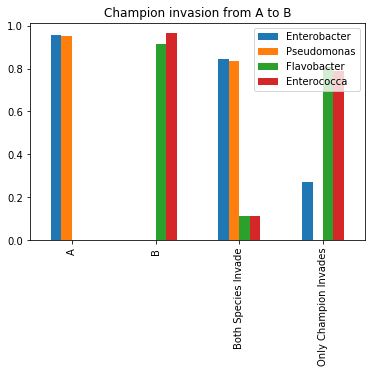

In [15]:
from community_simulator.visualization import StackPlot
import matplotlib.pyplot as plt
%matplotlib inline
MyPlate.N.T.plot.bar()
plt.gca().set_title('Champion invasion from A to B')
plt.gca().set_xticklabels(['A','B','Both Species Invade','Only Champion Invades'])
plt.show()

In this example (without crossfeeding), the champion does better when invading together with Pseudomonas than it does alone. I contrived the example to have this result, by making the two species of community A almost perfect specialists, and those of B almost perfect generalists. If the consumer matrices for both communities had been drawn from the same probability distribution, it would have been very hard to achieve this result.

# Crossfeeding

The above examples were all run in the original MacArthur Consumer Resource Model, without crossfeeding. But the most interesting model predictions come from the addition of crossfeeding. As will be discussed in detail in future documentation, we assume that a fraction $e_\beta$ of the energy contained in the incoming flux of resource $\beta$ is used for growth, and the rest of the energy is released into the environment in the form of secreted byproducts (and heat). We define a metabolic matrix $D_{\alpha \beta}$ that determines how this outgoing flux is partitioned among the various byproducts, to arrive at the following equations:

\begin{align}
\frac{dN_i}{dt} &= N_i g_i \left[ \sum_\beta e_\beta w_\beta c_{i\beta} R_\beta - m_i\right]\\
\frac{dR_\alpha}{dt} &=  - R_\alpha \sum_j c_{j\alpha}N_j +\sum_{\beta, j} (1-e_\beta) \frac{w_\beta}{w_\alpha}D_{\alpha \beta}c_{j\beta}N_j R_\beta.
\end{align}

The `usertools` submodule contains a function for generating random $c_{i\alpha}$ and $D_{\alpha\beta}$ matrices, with the sampling performed in such a way that members of different families of consumers can prefer different types of resources. This will be explained in more detail in future documentation. For now, we will just use the default settings and demonstrate how it runs:

In [16]:
from community_simulator.usertools import MakeMatrices
c, D = MakeMatrices()

The consumers defined by this $c_{i\alpha}$ matrix come in four families, labeled F0, F1 and F2 and GEN. The resources come in three types, T0, T1 and T2. Each family contains twenty consumer species, and each type contains twenty-five resource species. Each of the first three families prefers a particular type of resources (F0 prefers T0, etc.), while the generalists GEN have equal preference across all types.

In [17]:
c

T0                                                              \
               R0        R1        R2        R3        R4        R5        R6   
F0  S0   0.115284  0.099228  0.109657  0.101181  0.115935  0.094262  0.096130   
    S1   0.102411  0.085993  0.099079  0.091247  0.100747  0.097463  0.102067   
    S2   0.115502  0.093806  0.112134  0.101329  0.100349  0.088979  0.088298   
    S3   0.102976  0.084116  0.094365  0.085906  0.109879  0.093010  0.119877   
    S4   0.105084  0.084122  0.099128  0.110664  0.087226  0.102411  0.093798   
    S5   0.104858  0.106901  0.088885  0.104494  0.097458  0.097984  0.102809   
    S6   0.085028  0.105627  0.106564  0.094297  0.100347  0.086330  0.096373   
    S7   0.107543  0.105036  0.095706  0.095922  0.098135  0.096606  0.107844   
    S8   0.100846  0.086909  0.103699  0.093498  0.092161  0.085886  0.083420   
    S9   0.082598  0.109680  0.089474  0.123771  0.097892  0.100676  0.097992   
    S10  0.094712  0.082656  0.100257  0.085704  0.089191  0.083818  0.103173   
    S11  0.099699  0.112649  0.110259  0.108627  0.113923  0.108493  0.095977   
    S12  0.094729  0.099478  0.092571  0.104727  0.081100  0.103453  0.092692   
    S13  0.092653  0.099121  0.105928  0.089786  0.108631  0.100817  0.110719   
    S14  0.107054  0.086751  0.104292  0.094574  0.105780  0.111455  0.115115   
    S15  0.117586  0.087719  0.096216  0.083463  0.088398  0.113764  0.109123   
    S16  0.107181  0.105281  0.100497  0.096856  0.094432  0.096150  0.107089   
    S17  0.108103  0.101840  0.092237  0.078391  0.089305  0.113316  0.095675   
    S18  0.117337  0.093623  0.099511  0.100987  0.094214  0.112700  0.090351   
    S19  0.101173  0.080869  0.108944  0.106961  0.101359  0.098355  0.086627   
F1  S20  0.105154  0.106574  0.094699  0.085872  0.110576  0.085824  0.088404   
    S21  0.118928  0.090190  0.096855  0.116558  0.097347  0.105304  0.099820   
    S22  0.100539  0.104373  0.105807  0.115499  0.091365  0.117562  0.113499   
    S23  0.114406  0.071937  0.099884  0.082119  0.096035  0.091425  0.102136   
    S24  0.093289  0.087676  0.095739  0.085332  0.110855  0.092645  0.112963   
    S25  0.082187  0.093585  0.107806  0.101256  0.119715  0.086819  0.093099   
    S26  0.103857  0.092337  0.095603  0.104455  0.096732  0.095045  0.111095   
    S27  0.084822  0.096593  0.101056  0.086959  0.097952  0.091627  0.090913   
    S28  0.099104  0.098472  0.111452  0.089407  0.089431  0.115369  0.105136   
    S29  0.088032  0.098856  0.109298  0.106308  0.095557  0.089658  0.095788   
...           ...       ...       ...       ...       ...       ...       ...   
F3  S70  0.086846  0.083781  0.093729  0.099688  0.062726  0.101774  0.105956   
    S71  0.111505  0.121692  0.095605  0.102733  0.093051  0.110827  0.084723   
    S72  0.099225  0.092992  0.087979  0.108422  0.104683  0.096777  0.095347   
    S73  0.093437  0.112783  0.102125  0.087010  0.106662  0.086556  0.112454   
    S74  0.112310  0.113981  0.103298  0.103846  0.096436  0.106218  0.112570   
    S75  0.117889  0.100709  0.097949  0.105077  0.107785  0.089146  0.105544   
    S76  0.087376  0.101547  0.101597  0.086133  0.113996  0.097798  0.096155   
    S77  0.090435  0.105687  0.106382  0.107629  0.093415  0.101322  0.112525   
    S78  0.099936  0.103247  0.099315  0.107525  0.098054  0.113072  0.123758   
    S79  0.090462  0.098973  0.102329  0.095824  0.093740  0.100057  0.111616   
GEN S80  0.096495  0.106086  0.098304  0.106100  0.086134  0.095131  0.084284   
    S81  0.089694  0.095036  0.104210  0.086662  0.107149  0.111288  0.100407   
    S82  0.081046  0.105297  0.103768  0.115748  0.119744  0.084990  0.096024   
    S83  0.087492  0.109735  0.096186  0.105090  0.102939  0.095076  0.100769   
    S84  0.093418  0.095898  0.096222  0.102172  0.104583  0.106433  0.135598   
    S85  0.104823  0.111315  0.107397  0.092886  0.103490  0.111128  0.077704   
    S86  0.105027  0.082588  0.090332  0.07788

The $D_{\alpha\beta}$ matrix is structured to reflect the rough features of biochemistry: a fraction $f_w$ of byproducts secreted from any metabolic channel are 'waste' molecules (carboxylic acids). Most of the remaining secretion, occupying a fraction $f_s$ of the total, is of the same type as the source molecule: modified sugars are lost during sugar metabolism, amino acids are lost during amino acid metabolism, etc. We partition the rest of the secretion randomly among all molecular species. In the following example, T0 contains the carboxylic acids.

In [18]:
D

T0                                                          \
                  R0            R1            R2            R3            R4   
T0 R0   2.905661e-14  3.831864e-01  3.627842e-04  3.239265e-06  1.433000e-08   
   R1   2.993764e-43  1.219877e-05  1.726386e-19  4.780904e-04  2.069253e-09   
   R2   6.990335e-07  2.826107e-09  5.776614e-26  7.076096e-08  4.557209e-02   
   R3   5.121970e-11  1.616532e-09  2.811296e-05  3.006137e-18  1.330494e-10   
   R4   5.128591e-04  5.471860e-26  1.744749e-11  4.114241e-07  5.020027e-08   
   R5   8.921810e-54  1.270276e-07  4.012932e-03  3.181835e-05  1.530726e-02   
   R6   3.282273e-03  1.444592e-11  1.923811e-01  6.425394e-11  3.023196e-05   
   R7   7.849373e-05  1.036625e-20  1.473279e-02  3.853480e-03  1.957192e-02   
   R8   4.969508e-22  1.271573e-01  1.672913e-08  1.706102e-18  2.547265e-05   
   R9   2.952013e-08  3.557200e-17  1.032859e-04  3.402942e-04  3.526215e-18   
   R10  1.058661e-08  8.698636e-04  1.762200e-08  6.760633e-11  3.760697e-06   
   R11  1.298373e-01  8.929832e-16  2.240168e-11  7.466369e-03  7.191041e-04   
   R12  2.369811e-05  7.311178e-11  3.819703e-02  7.645074e-13  1.028872e-10   
   R13  3.204625e-06  2.014326e-12  6.721882e-08  9.403780e-02  2.203480e-10   
   R14  3.721684e-07  1.870165e-14  2.593051e-09  9.159832e-06  2.164454e-11   
   R15  1.452791e-22  6.700464e-26  9.960613e-09  1.644712e-08  7.510224e-08   
   R16  6.019821e-13  5.758454e-35  8.796181e-13  2.253558e-13  3.430760e-14   
   R17  4.722097e-20  4.964346e-08  3.245693e-12  1.724034e-02  4.008658e-05   
   R18  6.377352e-05  6.136375e-23  9.536255e-04  3.039217e-05  3.494747e-05   
   R19  2.023204e-04  8.220149e-03  2.585171e-08  5.237972e-04  1.157709e-05   
   R20  4.288606e-06  8.097388e-18  3.868649e-15  1.799324e-03  8.103051e-09   
   R21  2.495045e-02  5.465610e-32  7.670167e-02  2.027932e-21  1.786763e-20   
   R22  1.772742e-30  1.242227e-05  1.216693e-26  1.115695e-11  1.276049e-04   
   R23  1.033946e-11  1.140127e-11  1.527731e-04  5.208785e-29  1.465233e-01   
   R24  5.695463e-05  1.568441e-03  7.095990e-05  3.326795e-09  1.306051e-02   
T1 R25  1.435775e-06  1.262974e-22  1.954239e-22  6.235395e-09  2.269354e-08   
   R26  1.836440e-15  1.036361e-02  6.964837e-26  4.618470e-05  1.303065e-09   
   R27  4.651978e-31  1.700991e-14  1.052896e-07  7.330858e-09  1.197005e-07   
   R28  1.593713e-50  1.609240e-07  2.457562e-14  3.301762e-05  4.460638e-15   
   R29  1.109718e-04  1.889881e-10  1.214949e-04  4.021589e-06  1.009033e-24   
...              ...           ...           ...           ...           ...   
T2 R70  6.466517e-26  1.278365e-26  3.185888e-05  9.914764e-05  2.006221e-06   
   R71  1.741646e-14  9.990107e-04  7.865652e-06  6.102087e-18  2.900160e-24   
   R72  3.799063e-03  3.818080e-04  2.113690e-03  3.852368e-08  8.675906e-03   
   R73  9.862655e-13  3.367695e-03  3.498450e-02  2.677344e-05  1.383807e-02   
   R74  1.519966e-24  1.836731e-05  1.915767e-23  1.853630e-01  1.144983e-10   
T3 R75  1.791313e-17  1.340613e-03  7.730253e-32  2.363292e-07  4.865739e-09   
   R76  1.659343e-15  2.035506e-03  2.095954e-05  1.103250e-05  3.857835e-12   
   R77  9.296568e-16  8.240394e-05  2.497760e-10  9.696895e-17  1.157224e-02   
   R78  6.091541e-10  4.821071e-04  7.218960e-08  1.360060e-10  3.535219e-02   
   R79  6.738258e-02  2.961819e-17  3.602240e-04  1.995453e-02  3.108890e-02   
   R80  9.359831e-08  1.948320e-16  3.631974e-08  5.008462e-13  6.359547e-07   
   R81  2.192661e-04  3.365682e-06  6.440594e-04  3.490721e-06  1.641019e-01   
   R82  1.376258e-07  6.154771e-08  1.865918e-15  6.391259e-10  7.655425e-05   
   R83  2.441437e-17  2.510078e-10  3.199113e-08  1.595664e-14  5.057258e-14   
   R84  7.714203e-07  4.306910e-14  1.997952e-07  1.130042e-07  1.583393e-04   
   R85  6.934791e-24  1.027783e-11  1.797312e-02  4.638148e-03  5.930881e-02   
   R86  5.382394e-24  1.958909e-01  3.857084e-29  7.251507e-08  9.555496e-08   
   R87  6.922645e-

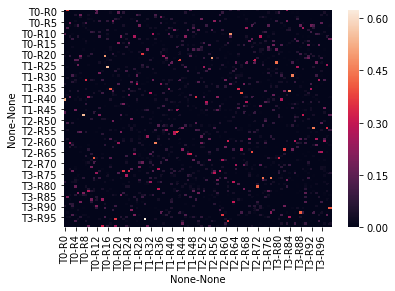

In [19]:
import seaborn as sns
sns.heatmap(D)
plt.show()

Note that none of the input parameters have to be dataframes, but it's convenient to use them for pedagogical purposes. Let's simulate batch culture of this community in 5 wells. We will supply 10 units of resource R8 in each fresh well, but none of the other resources.

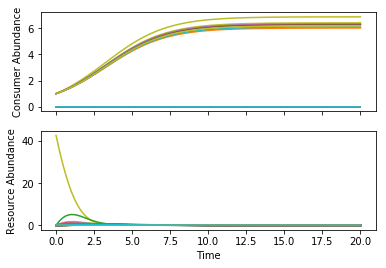

In [32]:
from community_simulator.usertools import BinaryRandomMatrix
from community_simulator import Community
import numpy as np
from community_simulator.usertools import MakeConsumerDynamics,MakeResourceDynamics,AddLabels
import pandas as pd

#Set experiment parameters
S_tot = len(c)
S_well = 8.5
n_wells = 5
M = len(D)

#Compute probability of finding a given species in a given well
p = S_well*1./S_tot

#Create initial conditions
N0 = BinaryRandomMatrix(S_tot,n_wells,p)
R0 = np.zeros((M,n_wells))
R0[8] = 5*S_well
N0,R0 = AddLabels(N0,R0,c)
init_state = [N0,R0]

#Construct dynamics
assumptions = {'regulation':'independent','replenishment':'off','response':'type I'}
def dNdt(N,R,params):
    return MakeConsumerDynamics(**assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(**assumptions)(N,R,params)
dynamics = [dNdt,dRdt]
e = 0.1

#Create parameter set
params={'c':c,
        'm':np.ones(S_tot)*1e-9,
        'w':np.ones(M),
        'D':D,
        'g':np.ones(S_tot),
        'e':e
       }

MyPlate = Community(init_state,dynamics,params,scale=10**9)

t, Ntraj, Rtraj = MyPlate.TestWell(T=20)

Note that the resources that were not added by hand start to accumulate around time 1, and then are consumed and drop back to zero.

Now let's run 7 dilution cycles and plot the composition after each cycle for all five wells:

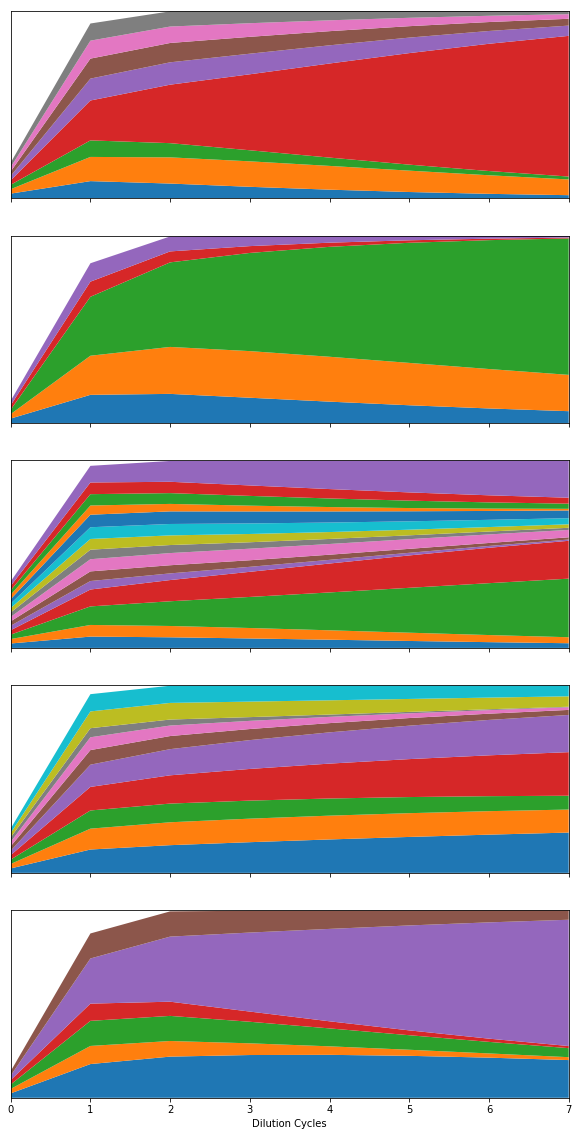

In [33]:
from community_simulator.visualization import PlotTraj
import matplotlib.pyplot as plt

f = np.eye(n_wells)*1e-2
N_traj, R_traj = MyPlate.RunExperiment(f,20,7)

PlotTraj(N_traj,figsize=(10,20))
plt.show()

In [22]:
MyPlate.N

W0            W1   W2            W3            W4
F0  S0   0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S1   0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S2   0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S3   0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S4   0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S5   0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S6   0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S7   0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S8   0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S9   0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S10  0.000000e+00  3.410852e-06  0.0  0.000000e+00  2.840107e-06
    S11  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S12  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S13  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S14  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S15  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S16  4.874593e-07  0.000000e+00  0.0  8.124322e-07  0.000000e+00
    S17  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S18  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S19  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
F1  S20  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S21  0.000000e+00  7.789424e-07  0.0  0.000000e+00  0.000000e+00
    S22  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S23  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S24  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S25  0.000000e+00  0.000000e+00  0.0  0.000000e+00  1.011736e-04
    S26  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S27  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S28  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S29  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
...               ...           ...  ...           ...           ...
F3  S70  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S71  0.000000e+00  4.506696e-05  0.0  0.000000e+00  0.000000e+00
    S72  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S73  0.000000e+00  0.000000e+00  0.0  3.393896e-07  0.000000e+00
    S74  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S75  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S76  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S77  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S78  0.000000e+00  0.000000e+00  0.0  0.000000e+00  9.288183e-07
    S79  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
GEN S80  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S81  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S82  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S83  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S84  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S85  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S86  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S87  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S88  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S89  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S90  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S91  1.494769e-07  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S92  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S93  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S94  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S95  0.000000e+00  0.000000e+00  0.0  0.000000e+00  0.000000e+00
    S96  0.000000

# Continuous Culture

This package was originally designed for doing batch culture, but it also includes options for continuous culture. The resource dynamics are modeled by functions of the form
\begin{align}
\frac{dR_\alpha}{dt} =h_\alpha (R_\alpha) - \sum_j N_j \nu_{j \alpha}^{\mathrm{in}} + \sum_j N_j \nu_{j \alpha}^{\mathrm{out}},
\end{align}
The default setting in MakeResourceDynamics is to not have any continuous replenishment of resources (`replenishment='off'`), since the resources are resupplied at the beginning of every batch. This is equivalent to setting $h_\alpha = 0$ in the above equation. But you can set `replenishment='non-renew'` to model "non-renewable" or "biotic" resources with logistic growth that are capable of going extinct:
\begin{align}
h_\alpha^{\mathrm{non-renew}} (R_\alpha) = r_\alpha R_\alpha (R_\alpha^0-R_\alpha)
\end{align}
or `replenishment='renew'` to model "renewable" or "abiotic" resources with a linear functional form, which does not allow resource extinction:
\begin{align}
h_\alpha^{\mathrm{renew}} (R_\alpha) = \tau_\alpha^{-1} (R_\alpha^0-R_\alpha).
\end{align}

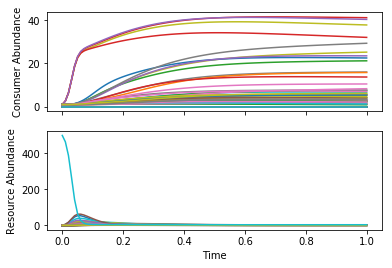

In [34]:
from community_simulator.usertools import MakeMatrices
from community_simulator.usertools import BinaryRandomMatrix
from community_simulator import Community
import numpy as np
from community_simulator.usertools import MakeConsumerDynamics,MakeResourceDynamics,AddLabels
import pandas as pd

species_per_family = 20
resources_per_type = 25
productivity = 500. #abundance of externally supplied resource in absence of consumers
q = 0 #degree of specialization
e = 0.2 #efficiency

pool_params = {'SA': species_per_family*np.ones(4), #Number of species in each family
          'MA': resources_per_type*np.ones(4), #Number of resources of each type
          'Sgen': species_per_family, #Number of generalist species
          'muc': 10, #Mean sum of consumption rates in Gaussian model
          'sigc': .1, #Variance in consumption rate in Gaussian model
          'q': q, #Preference strength 
          'c0':0.01, #Background consumption rate in binary model
          'c1':1., #Maximum consumption rate in binary model
          'fs':0.25, #Fraction of secretion flux with same resource type
          'fw':0.25, #Fraction of secretion flux to 'waste' resource
          'D_diversity':0.2 #Variability in secretion fluxes among resources (must be less than 1)
         }
c, D = MakeMatrices(metaparams = pool_params, kind = 'Binary')

#Create initial conditions (sub-sampling from regional species pool)
S_tot = len(c)
S_well = 50
n_wells = 5
M = len(D)
p = S_well*1./S_tot
N0 = BinaryRandomMatrix(S_tot,n_wells,p)
R0 = np.zeros((M,n_wells))
R0[-1,:] = productivity
N0,R0 = AddLabels(N0,R0,c)
init_state = [N0,R0]

#Construct dynamics
assumptions = {'regulation':'independent','replenishment':'renew','response':'type I'}
def dNdt(N,R,params):
    return MakeConsumerDynamics(**assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(**assumptions)(N,R,params)
dynamics = [dNdt,dRdt]

#Create parameter set
params={'c':c,
        'm':np.ones(S_tot)+0.1*np.random.randn(S_tot),
        'w':np.ones(M),
        'D':D,
        'g':np.ones(S_tot),
        'e':e,
        'R0':R0.values[:,0],
        'r':1.,
        'tau':1
       }

MyPlate = Community(init_state,dynamics,params)

t, Ntraj, Rtraj = MyPlate.TestWell(T=1)

Now let's run for a long time, periodically removing the species that are going extinct, to avoid numerical instabilities (using the multinomial sampling built in to RunExperiment).

In [35]:
Ntraj,Rtraj = MyPlate.RunExperiment(np.eye(n_wells),1,5,refresh_resource=False,scale=1e6)

In [36]:
Ntraj,Rtraj = MyPlate.RunExperiment(np.eye(n_wells),50,10,refresh_resource=False,scale=1e6)

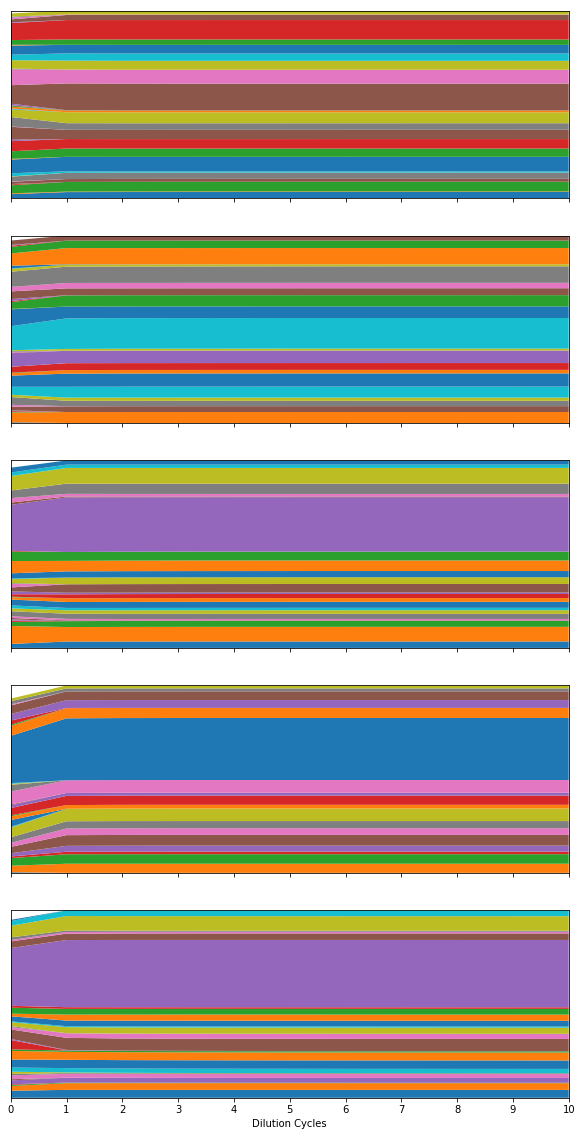

In [37]:
from community_simulator.visualization import PlotTraj
import matplotlib.pyplot as plt
%matplotlib inline

PlotTraj(Ntraj)
plt.show()

We get about 20 species surviving in each well:

In [38]:
(MyPlate.N>0).sum()

W0    24
W1    22
W2    24
W3    20
W4    27
dtype: int64

We can use the Pandas "groupby" feature to sort species by family. The total populations of each family should be fairly even, since family labels ar totally neutral in this simulation (q=0).

In [39]:
MyPlate.N.groupby(level=0).sum().mean(axis=1)

F0      60.923409
F1      68.014688
F2      58.196461
F3     166.345416
GEN    112.986146
dtype: float64

We can also generate heat maps, like the ones commonly used to present microbiome data.

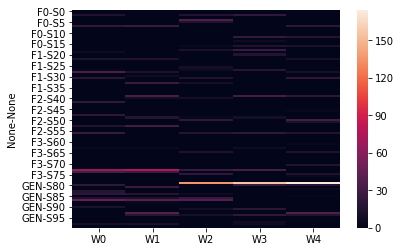

In [40]:
sns.heatmap(MyPlate.N)
plt.show()

# Diauxic Shifts

Setting 'regulation' equal to 'energy' or 'mass' will make each microbe specialize in the most abundant available energy source, weighted either in terms of potential energy flux or potential mass flux. This gives rise to diauxic shifts, where the microbes consume resources sequentially.

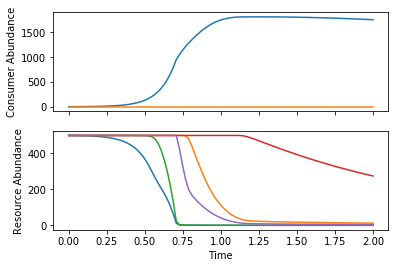

In [53]:
from community_simulator.usertools import MakeMatrices
from community_simulator.usertools import BinaryRandomMatrix
from community_simulator import Community
import numpy as np
from community_simulator.usertools import MakeConsumerDynamics,MakeResourceDynamics,AddLabels
import pandas as pd

M = 5
productivity = 500. #abundance of externally supplied resource in absence of consumers
e = 1.

pool_params = {'SA': np.asarray([2]), #Number of species in each family
          'MA': np.asarray([M]), #Number of resources of each type
          'Sgen': 0, #Number of generalist species
          'muc': 5, #Mean sum of consumption rates in Gaussian model
          'sigc': 3, #Variance in consumption rate in Gaussian model
          'q': 0, #Preference strength 
          'c0':0.01, #Background consumption rate in binary model
          'c1':1., #Maximum consumption rate in binary model
          'fs':0.25, #Fraction of secretion flux with same resource type
          'fw':0.25, #Fraction of secretion flux to 'waste' resource
          'D_diversity':0.2 #Variability in secretion fluxes among resources (must be less than 1)
         }
c, D = MakeMatrices(metaparams = pool_params, kind = 'Gamma')

#Create initial conditions (sub-sampling from regional species pool)
N0 = np.asarray([1,0])
R0 = np.ones(M)*productivity
#N0,R0 = AddLabels(N0,R0,c)
init_state = [N0,R0]

#Construct dynamics
assumptions = {'regulation':'energy','replenishment':'off','response':'type II'}
def dNdt(N,R,params):
    return MakeConsumerDynamics(**assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(**assumptions)(N,R,params)
dynamics = [dNdt,dRdt]

#Create parameter set
params={'c':c,
        'm':0.2,
        'w':1,
        'D':D,
        'g':1,
        'e':e,
        'R0':R0,
        'r':1.,
        'tau':1,
        'nreg':10,
        'K':10
       }

MyPlate = Community(init_state,dynamics,params)

t, Ntraj, Rtraj = MyPlate.TestWell(T=2)